### 0. Before start 
OK, to begin we need to import some standart Python modules

In [51]:
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 12 13:21:45 2016

@author: GrinevskiyAS
"""

from __future__ import division
import numpy as np
from numpy import sin,cos,tan,pi,sqrt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

%matplotlib inline


font = {'family': 'Arial', 'weight': 'normal', 'size':14}
mpl.rc('font', **font)
mpl.rc('figure', figsize=(10, 8))

### 1. Setup
First, let us setup the working area.

In [52]:
#This would be the size of each grid cell (X is the spatial coordinate, T is two-way time)
xstep = 5
tstep = 5

#size of the whole grid
xmax = 320
tmax = 220

#that's the arrays of x and t
xarray = np.arange(0, xmax, xstep).astype(float)
tarray = np.arange(0, tmax, tstep).astype(float)

#now fimally we created a 2D array img, which is now all zeros, but later we will add some amplitudes there
img = np.zeros((len(xarray), len(tarray)))

Let's show our all-zero image

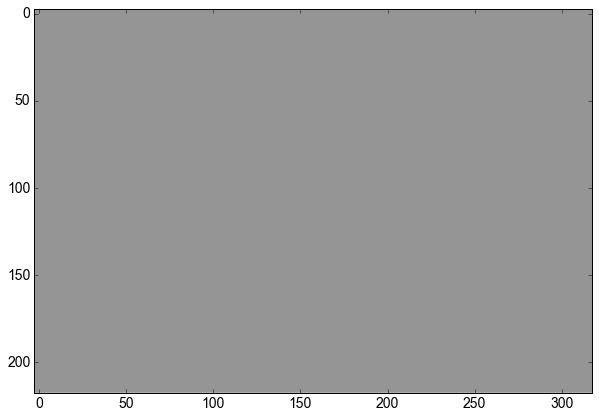

In [53]:
plt.imshow(img.T, interpolation = 'none', cmap = cm.Greys, vmin = -2,vmax = 2,
           extent = [xarray[0] - xstep/2, xarray[-1] + xstep/2, tarray[-1] + tstep/2, tarray[0] - tstep/2])

### 2. Main class definition

What we are now going to do is create a class named **`Hyperbola`**

Each object of this class is capable of computing traveltimes to a certain subsurface point (diffractor) and plotting this point response (hyperbola) on a grid


**How?** to more clearly define a class? probably change to a function?

In [54]:
class Hyperbola:
    def __init__(self, xarray, tarray, x0, t0, v=2):
        """
        input parameters define a difractor's position (x0,t0), 
        P-wave velocity of homogeneous subsurface, 
        and x- and t-arrays to compute traveltimes on.
        """
        
        self.x = xarray
        self.x0 = x0
        self.t0 = t0
        self.v = v
        
        #compute traveltimes
        self.t = sqrt(t0**2 + (2*(xarray-x0)/v)**2)
        
        #obtain some grid parameters
        xstep = xarray[1]-xarray[0]
        tbegin = tarray[0]
        tend = tarray[-1]
        tstep = tarray[1]-tarray[0]
        
        #delete t's and x's for samples where t exceeds maxt
        self.x = self.x[ (self.t >= tbegin) & (self.t <= tend) ]        
        self.t = self.t[ (self.t >= tbegin) & (self.t <= tend) ]
        
        #compute indices of hyperbola's X coordinates in xarray
        #self.imgind = ((self.x - xarray[0])/xstep).astype(int)       
        
        #compute how amplitudes decrease according to geometrical spreading
        self.amp = 1/(self.t/self.t0)

        self.grid_resample(xarray, tarray)
        
    
    def grid_resample(self, xarray, tarray):
        """that's a function that computes at which 'cells' of image we should place the hyperbola"""
    
        tend=tarray[-1]
        tstep=tarray[1]-tarray[0]
        
        self.xind=((self.x-xarray[0])/xstep).astype(int)  #X cells numbers
        
        self.tind=np.round((self.t - tarray[0])/tstep).astype(int) #T cells numbers
        self.tind=self.tind[self.tind*tstep <= tarray[-1]] #delete T's exceeding max T
        
        self.tgrid=tarray[self.tind] # get 'gridded' T-values
        
        #self.coord=np.vstack((self.xind,tarray[self.tind]))    
        
            
    def add_to_img(self, img, wavelet):
        """puts the hyperbola into the right cells of image with a given wavelet"""
        
        maxind = np.size(img,1)
        wavlen = np.floor(len(wavelet)/2).astype(int)      
        
        # to ensure that we will not exceed image size
        #self.imgind=self.xind[self.tind < maxind-wavlen-1]        
        #self.amp = self.amp[self.tind < maxind-wavlen-1]
        #self.tind=self.tind[self.tind < maxind-wavlen-1]
        
        ind_begin = self.tind-wavlen
        ind_to_use = self.tind < maxind-wavlen-1
        
        #add amplitudes of the wavelet to the image
        for i,sample in enumerate(wavelet):
            img[self.xind[ind_to_use], ind_begin[ind_to_use]+i] = img[self.xind[ind_to_use],ind_begin[ind_to_use]+i] + sample*self.amp[ind_to_use]
        return img

For testing purposes, let's create an object named Hyp_test and view its parameters

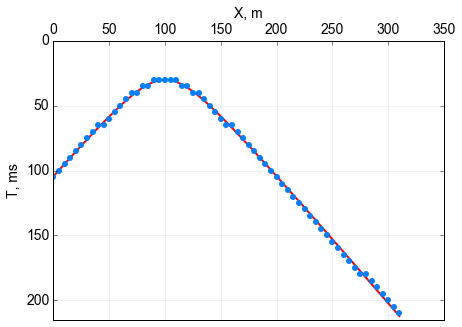

In [55]:
Hyp_test = Hyperbola(xarray, tarray, x0 = 100, t0 = 30, v = 2)

#Create a fugure and add axes to it
fgr_test1 = plt.figure(figsize=(7,5), facecolor='w')
ax_test1 = fgr_test1.add_subplot(111)

#Now plot Hyp_test's parameters: X vs T
ax_test1.plot(Hyp_test.x, Hyp_test.t, 'r', lw = 2)
#and their 'gridded' equivalents
ax_test1.plot(Hyp_test.x, Hyp_test.tgrid, ls='none', marker='o', ms=6, mfc=[0,0.5,1],mec='none')

#Some commands to add gridlines, change the directon of T axis and move x axis to top
ax_test1.set_ylim(tarray[-1],tarray[0])
ax_test1.xaxis.set_ticks_position('top')
ax_test1.grid(True, alpha = 0.1, ls='-',lw=.5)

ax_test1.set_xlabel('X, m')
ax_test1.set_ylabel('T, ms')
ax_test1.xaxis.set_label_position('top')

plt.show()

### 3. Creating the model and 'forward modelling'

OK, now let's define a subsurface model. For the sake of simplicity, the model will consist of two types of objects:
1. Point diffractor in a homogeneous medium
  * defined by their coordinates $(x_0, t_0)$ in data domain. 
2. Plane reflecting surface
  * defined by their end points $(x_1, t_1)$ and $(x_2, t_2)$, also in data domain.


We will be able to add any number of these objects to image.


Let's start by adding three point diffractors:

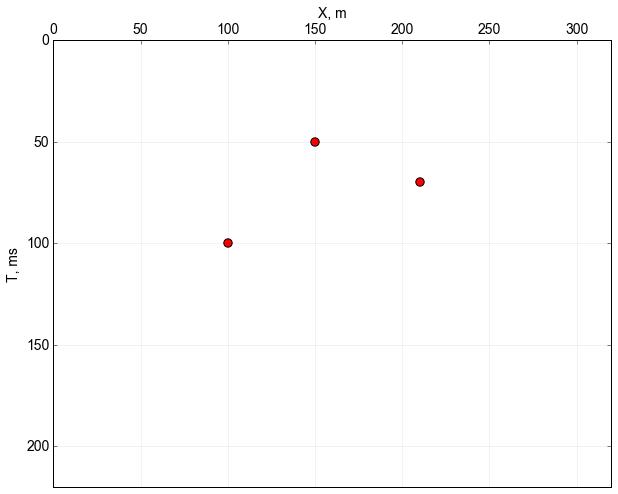

In [56]:
point_diff_x0 = [100, 150, 210]
point_diff_t0 = [100, 50, 70]

plt.scatter(point_diff_x0,point_diff_t0, c='r',s=70)
plt.xlim(0, xmax)
plt.ylim(tmax, 0)
plt.gca().set_xlabel('X, m')
plt.gca().set_ylabel('T, ms')
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.gca().grid(True, alpha = 0.1, ls='-',lw=.5)

Next step is computing traveltimes for these subsurface diffractors. This is done by creating an instance of `Hyperbola` class for every diffractor.



In [57]:
hyps=[]
for x0,t0 in zip(point_diff_x0,point_diff_t0):
    hyp_i = Hyperbola(xarray, tarray, x0, t0, v=2)
    hyps.append(hyp_i)

~~Next step is computing Green's functions for these subsurface diffractors. To do this, we need to setup a wavelet.~~
Of course, we are going to create an extremely simple wavelet.

(-2, 3)

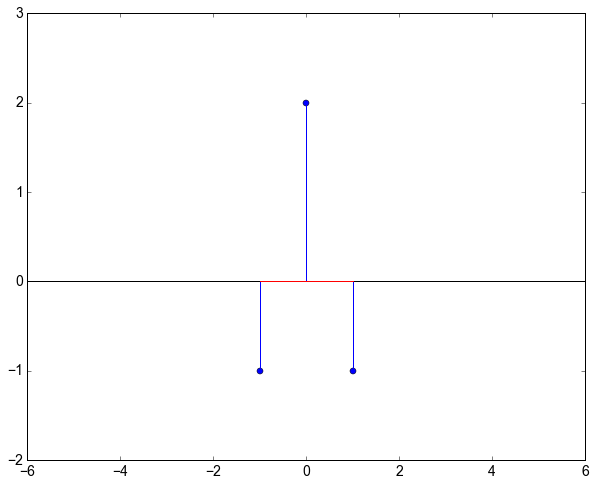

In [78]:
wav1 = np.array([-1,2,-1])

plt.axhline(0,c='k')
markerline, stemlines, baseline = plt.stem((np.arange(len(wav1)) - np.floor(len(wav1)/2)).astype(int), wav1)
plt.gca().set_xlim(-2*len(wav1), 2*len(wav1))
plt.gca().set_ylim(np.min(wav1)-1, np.max(wav1)+1)
    


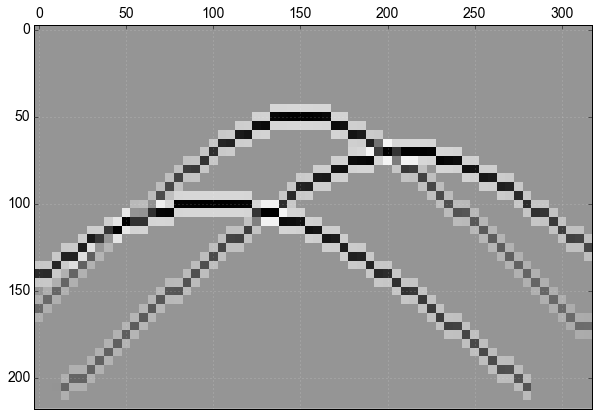

In [59]:
for hyp_i in hyps:
    hyp_i.add_to_img(img,wav1)

plt.imshow(img.T,interpolation='none',cmap=cm.Greys, vmin=-2,vmax=2, extent=[xarray[0]-xstep/2, xarray[-1]+xstep/2, tarray[-1]+tstep/2, tarray[0]-tstep/2])
plt.gca().xaxis.set_ticks_position('top')
plt.gca().grid(ls=':', alpha=0.25, lw=1, c='w' )

 Define a **`Line`** class

In [60]:
class Line:
    def __init__(self, xmin, xmax, tmin, tmax, xarray, tarray):
        """a Line object is decribed by its start and end coordinates"""
        self.xmin=xmin
        self.xmax=xmax
        self.tmin=tmin
        self.tmax=tmax
        xstep=xarray[1]-xarray[0]
        tstep=tarray[1]-tarray[0]
        
        xmin=xmin-np.mod(xmin,xstep)
        xmax=xmax-np.mod(xmax,xstep)
        tmin=tmin-np.mod(tmin,tstep)
        tmax=tmax-np.mod(tmax,tstep)
        
        self.x = np.arange(xmin,xmax+xstep,xstep)
        self.t = tmin+(tmax-tmin)*(self.x-xmin)/(xmax-xmin)
                
        self.imgind=((self.x-xarray[0])/xstep).astype(int)
        self.tind=((self.t-tarray[0])/tstep).astype(int)
        
            
    
    def add_to_img(self, img, wavelet):
        
        maxind=np.size(img,1)        
        wavlen=np.floor(len(wavelet)/2).astype(int)      
        
        self.imgind=self.imgind[self.tind < maxind-1]        
        self.tind=self.tind[self.tind < maxind-1]
        ind_begin=self.tind-wavlen                
        

        for i, sample_amp in enumerate(wavelet):
                img[self.imgind,ind_begin+i]=img[self.imgind,ind_begin+i] + sample_amp
        return img

Create a line and add it to image

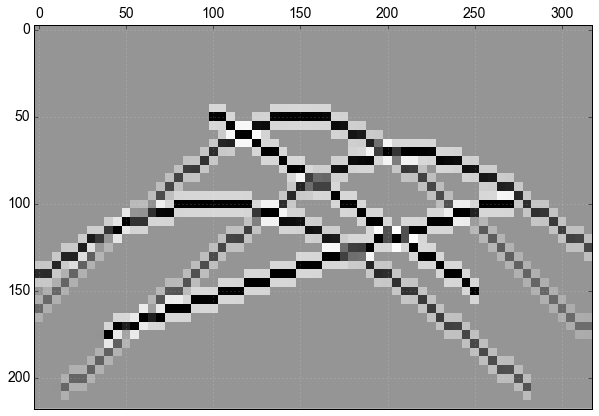

In [61]:
line1=Line(100,250,50,150,xarray,tarray)
img=line1.add_to_img(img, wav1)
line2=Line(40,270,175,100,xarray,tarray)
img=line2.add_to_img(img, wav1

plt.imshow(img.T, interpolation='none', cmap=cm.Greys, vmin=-2, vmax=2, 
           extent=[xarray[0]-xstep/2, xarray[-1]+xstep/2, tarray[-1]+tstep/2, tarray[0]-tstep/2])
plt.gca().xaxis.set_ticks_position('top')
plt.gca().grid(ls=':', alpha=0.25, lw=1, c='w' )

Excellent. The image now is pretty messy, so we need to migrate it and see what we can achieve 

### 4. Migration definition

In [62]:
def migrate(img, v, aper, xarray, tarray):
    imgmig=np.zeros_like(img)
    xstep=xarray[1]-xarray[0]

    for x0 in xarray:    
        for t0 in tarray[1:-1]:
            #only a region between (x0-aper) and (x0+aper) should be taken into account
            xmig=xarray[(x0-aper <= xarray) & (xarray <= x0+aper)]
           
            hi = Hyperbola(xmig,tarray,x0,t0,v)

            migind_start = hi.x[0]/xstep
            migind_stop = (hi.x[-1]+xstep)/xstep
            
            hi.imgind=np.arange(migind_start, migind_stop).astype(int)
            #Sum (in fact, count the mean value of) all the amplitudes on current hyperbola hi
            si = np.mean(img[hi.imgind,hi.tind]*hi.amp)
            imgmig[(x0/xstep).astype(int),(t0/tstep).astype(int)] = si

    return imgmig
            

### 5. Migration application

In [63]:
vmig = 2
aper = 200
res = migrate(img, vmig, aper, xarray, tarray)

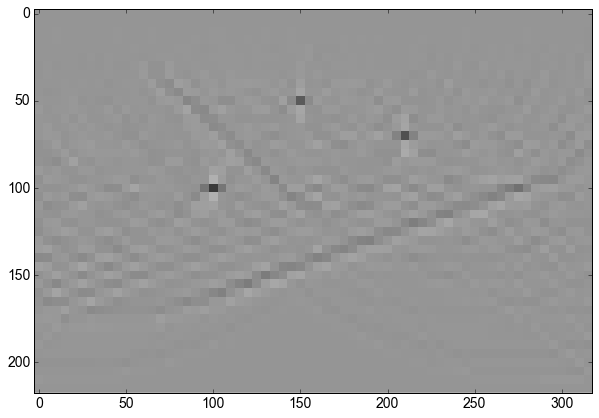

In [64]:
plt.imshow(res.T,interpolation='none',vmin=-2,vmax=2,cmap=cm.Greys, extent=[xarray[0]-xstep/2, xarray[-1]+xstep/2, tarray[-1]+tstep/2, tarray[0]-tstep/2])


Excellent!

The next section is only for interactive  parameter selection


### 6. Interactive parameter change

In [65]:
def migshow(vmig_i, aper_i, gain_i, interp):
    res_i = migrate(img, vmig_i, aper_i, xarray, tarray)
    if interp: 
        interp_style = 'bilinear'
    else:
        interp_style = 'none'
            
    plt.imshow(res_i.T,interpolation=interp_style,vmin=-gain_i,vmax=gain_i,cmap=cm.Greys, extent=[xarray[0]-xstep/2, xarray[-1]+xstep/2, tarray[-1]+tstep/2, tarray[0]-tstep/2])
    plt.title('Vmig = '+str(vmig_i))
    plt.show()

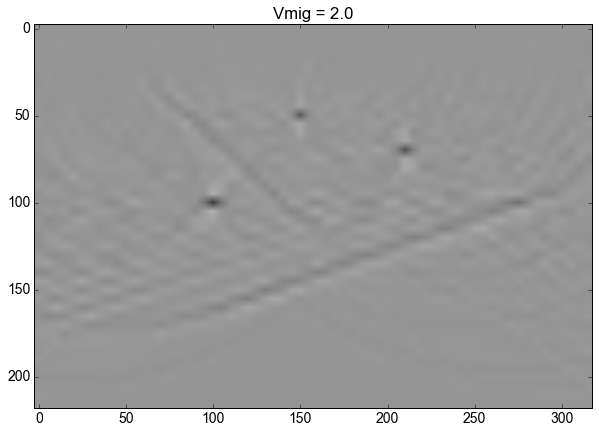

<function __main__.migshow>

In [66]:

interact(migshow, vmig_i = widgets.FloatSlider(min = 1.0,max = 3.0, step = 0.01, value=2.0,continuous_update=False,description='Migration velocity: '),
         aper_i = widgets.IntSlider(min = 10,max = 500, step = 1, value=200,continuous_update=False,description='Migration aperture: '),
         gain_i = widgets.FloatSlider(min = 0.0,max = 5.0, step = 0.1, value=2.0,continuous_update=False,description='Gain: '),
         interp = widgets.Checkbox(value=True, description='interpolate'))
    
#interact(migrate, img=fixed(img), v = widgets.IntSlider(min = 1.0,max = 3.0, step = 0.1, value=2), aper=fixed(aper), xarray=fixed(xarray), tarray=fixed(tarray))
